<h3 style="color: #2E86C1; text-decoration: underline;">Contexte du probl√®me</h3>

Ce challenge porte sur la pr√©diction des rendements des actions, sur un march√© boursier. √âtant donn√© un ensemble de $ N $ actions et leurs rendements $ R_t $ √† un instant $ t $, l'objectif est de concevoir √† chaque instant $ t $ un vecteur $ S_{t+1} $ qui maximisera le chevauchement avec les rendements r√©els $ R_{t+1} $, c'est-√†-dire $ \langle S_{t+1}, R_{t+1} \rangle $. Ce probl√®me est abord√© avec un mod√®le factoriel lin√©aire, o√π les facteurs sont appris dans un espace de param√®tres non lin√©aire.


<h3 style="color: #2E86C1; text-decoration: underline;">Vue d'ensemble du mod√®le</h3>

Le mod√®le classique utilis√© pour pr√©dire les rendements des actions est un mod√®le lin√©aire :

$$
S_{t+1} = \sum_{\ell=1}^F \beta_\ell F_{t,\ell}
$$

O√π :

- $ F_{t,\ell} $ sont des facteurs explicatifs ou des caract√©ristiques.
- $ \beta_1, \dots, \beta_F $ sont les param√®tres du mod√®le qui sont appris lors de l'entra√Ænement.

Le challenge explore √©galement la possibilit√© de concevoir les facteurs eux-m√™mes, o√π $ F_{t,\ell} $ sont des fonctions lin√©aires des rendements pass√©s. Cela conduit √† la formulation suivante :

$$
F_{t,\ell} = \sum_{k=1}^D A_{k\ell} R_{t+1-k}
$$

Ici :

- $ A_\ell $ sont des vecteurs qui d√©finissent les facteurs, et
- $ D $ est la profondeur temporelle.

Les vecteurs $ A_1, \dots, A_F $ doivent √™tre orthonorm√©s, ce qui ajoute une contrainte non lin√©aire √† l'espace des param√®tres.

<h3 style="color: #2E86C1; text-decoration: underline;">Objectif</h3>

L'objectif est de concevoir et d'apprendre les facteurs $ F_{t,\ell} $ pour la pr√©diction des rendements des actions, tout en garantissant que les vecteurs $ A_1, \dots, A_F $ respectent la contrainte d'orthonormalit√©.

<h3 style="color: #2E86C1; text-decoration: underline;">Donn√©es</h3>

- **Donn√©es d'entra√Ænement** : Un dataframe contenant les rendements quotidiens de 50 actions sur une p√©riode de 754 jours (3 ans) est fourni. Ces donn√©es seront utilis√©es pour apprendre les param√®tres $ A $ et $ \beta $.
- **Donn√©es de test** : Un jeu de donn√©es de test est fourni, comportant les jours de rendements suivants les 250 jours des donn√©es d'entra√Ænement.

<h3 style="color: #2E86C1; text-decoration: underline;">Sortie attendue</h3>

La sortie attendue des participants est un vecteur contenant les param√®tres :

- Une matrice $ A $ de taille $ 250 \times 10 $, repr√©sentant les vecteurs de facteurs appris.
- Un vecteur $ \beta $ de taille $ 10 $, repr√©sentant les param√®tres du mod√®le.

Ces sorties doivent √™tre empil√©es dans un seul vecteur de taille $ 2510 $.

<h3 style="color: #2E86C1; text-decoration: underline;">M√©trique d'√©valuation</h3>

La performance du mod√®le est √©valu√©e par une m√©trique qui mesure l'alignement entre les rendements pr√©dits et les rendements r√©els pour les donn√©es de test, d√©finie comme suit :

$$
M_{\text{trique}}(A, \beta) = \frac{1}{504} \sum_{t=250}^{753} \frac{\langle S_t, R_t \rangle}{\|S_t\| \|R_t\|}
$$

Si la condition d'orthonormalit√© $ \langle A_i, A_j \rangle = \delta_{ij} $ est viol√©e, la m√©trique renverra -1. Sinon, la m√©trique variera entre -1 et 1.

<h3 style="color: #2E86C1; text-decoration: underline;">Strat√©gie de benchmarking</h3>

Une approche de base est fourni consistant √† g√©n√©rer des vecteurs orthonorm√©s al√©atoires $ A_1, \dots, A_F $, √† ajuster $ \beta $ par r√©gression lin√©aire sur les donn√©es d'entra√Ænement et √† s√©lectionner le meilleur r√©sultat en fonction de la m√©trique. La proc√©dure de benchmark est la suivante :

1. G√©n√©rer al√©atoirement $ A_1, \dots, A_F $.
2. Appliquer l'algorithme de Gram-Schmidt pour garantir l'orthonormalit√©.
3. Ajuster $ \beta $ en utilisant la r√©gression des moindres carr√©s.
4. Calculer la m√©trique et s√©lectionner le meilleur mod√®le.

Cela fournit une strat√©gie de r√©f√©rence pour comparer les solutions mod√©lis√©es.

<h3 style="color: #2E86C1; text-decoration: underline;">M√©thodologie</h3>

Dans un premier temps, nous allons d√©finir des features classiques des facteurs de rendement connus dans la litt√©rature, telles que :

Ensuite, √† partir de ces features, nous r√©aliserons un premier mod√®le lin√©aire simple afin d'obtenir une valeur de la m√©trique d'√©galit√© du mod√®le.

Nous obtiendrons ensuite un mod√®le non supervis√© gr√¢ce √† une ACP afin d'en extraire les facteurs explicatifs des rendements et d'observer les performances de ce mod√®le par rapport au mod√®le simple.

Nous effectuerons √©galement un mod√®le supervis√© (on verra lequel).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [5]:
# Chargement des donn√©es
path = '/Users/kemache/Documents/GitHub/Machine-Learning-Factors-for-Stock-Market-Returns-Prediction/' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'
X_train = X_train.iloc[:40,:] #Jeu de donn√©es d'entrainement
X_test = X_train.iloc[40:,:] # Jeu de donn√©es de validation

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'
Y_train = Y_train.iloc[:40,:] # Jeu de donn√©es de test
Y_test = Y_train.iloc[40:,:] # Jeu du test de validation (√† pr√©dire in fine par le mod√®le entrain√©))


# Affichage des premi√®res lignes des datasets
print("Aper√ßu des donn√©es X_train:")
print(X_train.head())
print("\nAper√ßu des donn√©es Y_train:")
print(Y_train.head())


Aper√ßu des donn√©es X_train:
date             0         1         2         3         4         5  \
stocksID                                                               
0        -0.018647 -0.013002 -0.010776 -0.016676 -0.005110  0.009092   
1        -0.008254 -0.022280  0.012173 -0.006820 -0.004055  0.012912   
2        -0.008404 -0.013629 -0.006044 -0.003425 -0.009522 -0.001353   
3        -0.022734 -0.006981 -0.008568 -0.010899 -0.017981  0.002485   
4        -0.024546 -0.008315 -0.007991 -0.003515  0.007872  0.007082   

date             6         7         8         9  ...       744       745  \
stocksID                                          ...                       
0        -0.011745  0.007120 -0.008451  0.009119  ... -0.012525 -0.011716   
1        -0.001293  0.009994 -0.002747  0.001664  ...  0.014432 -0.002255   
2        -0.000637  0.007640  0.001600  0.007416  ... -0.006245 -0.001329   
3        -0.011980  0.012446 -0.010636  0.003807  ... -0.005179 -0.003442   
4  

In [6]:

# V√©rification des valeurs manquantes par actif (ligne)
missing_values_per_stock = X_train.isnull().sum(axis=1)
missing_values_per_stock = missing_values_per_stock[missing_values_per_stock > 0]

if not missing_values_per_stock.empty:
    plt.figure(figsize=(10, 5))
    missing_values_per_stock.plot(kind="bar")
    plt.xlabel("Index des stocks")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.title("Valeurs manquantes par actif")
    plt.show()
else:
    print("Aucune valeur manquante d√©tect√©e dans X_train.")

print("Nombre de valeurs manquantes par actif:")
print(missing_values_per_stock)

# Remplacement des valeurs manquantes par la moyenne de chaque ligne
X_train = X_train.apply(lambda row: row.fillna(row.mean()), axis=1)

# V√©rification apr√®s imputation
total_missing_after = X_train.isnull().sum().sum()
print(f"Total de valeurs manquantes apr√®s imputation : {total_missing_after}")





Aucune valeur manquante d√©tect√©e dans X_train.
Nombre de valeurs manquantes par actif:
Series([], dtype: int64)
Total de valeurs manquantes apr√®s imputation : 0


## Analyse statistiques des donn√©es


Statistiques des actifs:
                  Mean       Std  Skewness  Kurtosis       Max       Min
stocksID                                                                
0         1.565039e-04  0.011626  0.373388  1.702471  0.059061 -0.042102
1         3.313147e-04  0.006856 -0.263619  1.613290  0.021139 -0.033115
2        -3.476568e-04  0.009378 -0.034502  0.976077  0.036398 -0.033386
3        -1.999018e-07  0.011018 -0.147188  0.981895  0.046312 -0.045707
4         1.057414e-04  0.011078 -0.132906  2.053168  0.056822 -0.046940


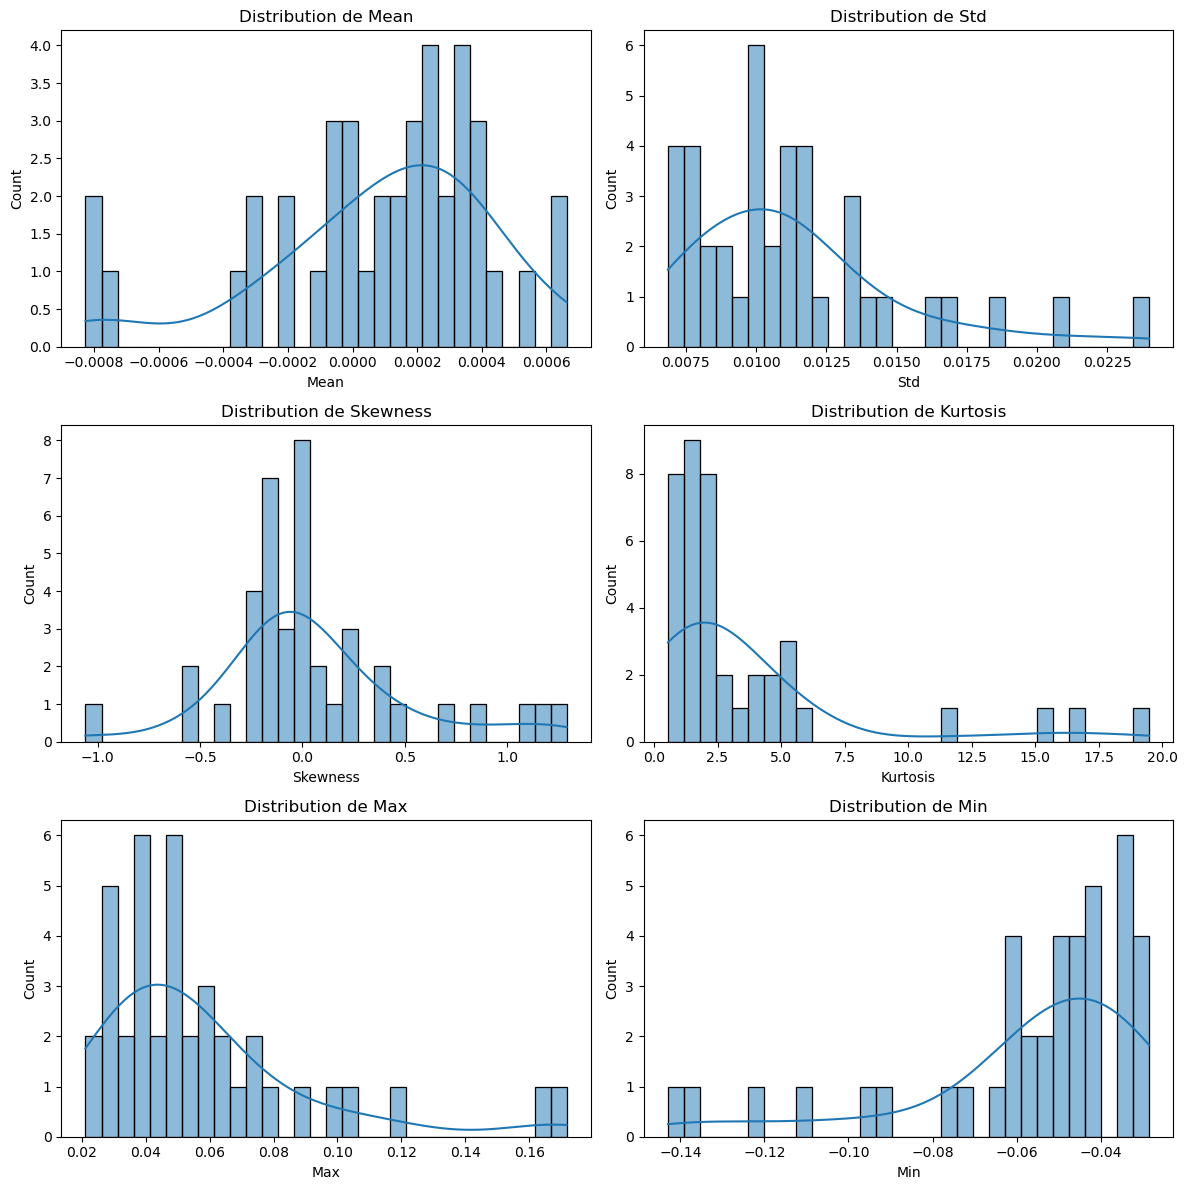

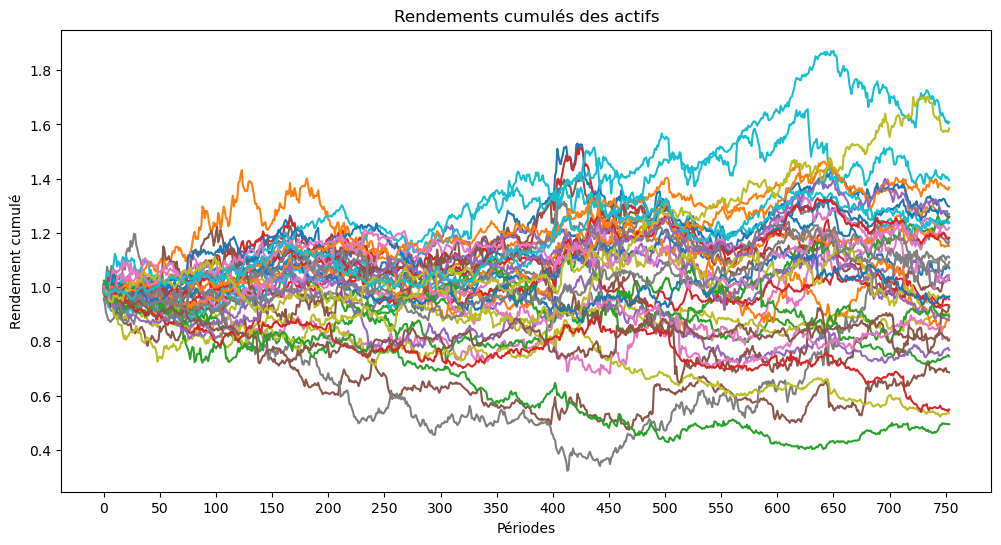

In [7]:
# Analyse statistique des donn√©es
stats_df = pd.DataFrame({
    "Mean": X_train.mean(axis=1),
    "Std": X_train.std(axis=1),
    "Skewness": X_train.skew(axis=1),
    "Kurtosis": X_train.kurtosis(axis=1),
    "Max": X_train.max(axis=1),
    "Min": X_train.min(axis=1)
})

print("\nStatistiques des actifs:")
print(stats_df.head())

# Visualisation des distributions des statistiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, column in enumerate(stats_df.columns):
    sns.histplot(stats_df[column], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution de {column}")

plt.tight_layout()
plt.show()

# Calcul des rendements cumul√©s
cumulative_returns = (1 + X_train).cumprod(axis=1)

# Trac√© des rendements cumul√©s
plt.figure(figsize=(12, 6))
for stock in cumulative_returns.index:
    plt.plot(cumulative_returns.columns, cumulative_returns.loc[stock])

plt.xticks(np.arange(0, len(cumulative_returns.columns), step=50))  # Affichage tous les 10 jours
plt.xlabel("P√©riodes")
plt.ylabel("Rendement cumul√©")
plt.title("Rendements cumul√©s des actifs")
plt.show()

## M√©thode de mod√©lisation du Beta et de la m√©trique d'accuracy (issue du notebook fourni par AQR)

In [8]:
# Reshape des donn√©es : reconstruit un nouveau dataframe avec les valeurs de X_train d√©cal√©es de 1 √† 250 jours. Chaque ligne represente un actif et une date, et chaque colonne repr√©sente un retard.
#Exemple, pour la premi√®re ligne on a l'actif 0 (le 1er) et si tu avances dans les colonnes tu as la valeur t-1, puis t-2 etc...

X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour repr√©senter chaque d√©calage temporel.


# to check the orthonormality constraints as in the metric:
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    #if any(Error.unstack() > 1e-6):
        #bool = False
    max_error = Error.values.max()  # Erreur maximale
    if max_error > 1e-6:
        print(f"‚ö†Ô∏è Probl√®me d'orthonormalit√© : max error = {max_error:.2e}")
        bool = False
        
    return bool

#G√©n√©ration des facteurs al√©atoires
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

#G√©n√®re un vecteur beta avec m premiers √©l√©ments non nuls
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

#Regression lineaire pour ajuster le vecteur beta √† partir des facteurs A et des variables cibles Y_train
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements √† pr√©dire (apres 250) et les facteurs et les rendements actuels (de 0 √† 250)
    
    return beta.to_numpy()

#Calcul de la m√©trique
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T #Pr√©diction avec les facteurs et les beta
    Ytrue = Y_train #Vrai valeurs des rendements
    
    # Normalisation des matrices en divisant chaque valeur par la norme (racine carr√©e de la somme des carr√©s).
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean() #Mesure la similarit√© entre les pr√©dictions et les vraies valeurs en calculant un produit scalaire moyen.


    return  meanOverlap 

## Benchmark

In [9]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = A = randomA()
    beta = fitBeta(A) # A partir des facrtors g√©n√©r√©s al√©atoirement, il va prendre pour chaque point de donn√©es, les 250 donn√©es pr√©c√©dement format√© a partir de X_reshape et va faire une regression lin√©aire pour pr√©dire les rendements futurs.
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

metric_train(A_QRT, beta_QRT) # public metric: 0.03535

print(f"Performance (metric_train): {maxMetric:.5f}")







0 metric_train: 0.03498249220188183
1 metric_train: 0.04175985816755471
31 metric_train: 0.046116712839033555
91 metric_train: 0.04933169735239696
421 metric_train: 0.05108624733831952
496 metric_train: 0.05151010749740387
675 metric_train: 0.05454273855058289
Performance (metric_train): 0.05454


üìä Performance du mod√®le :
‚úÖ Erreur quadratique moyenne (MSE) : 0.000147
‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : 0.0597


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


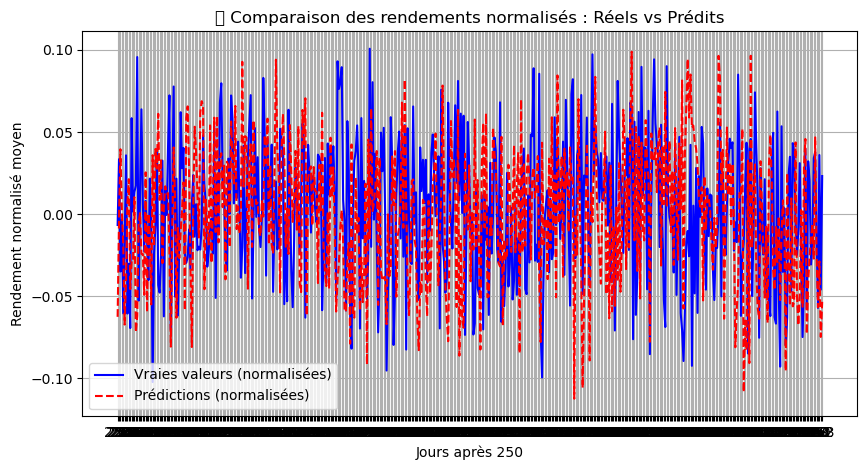

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


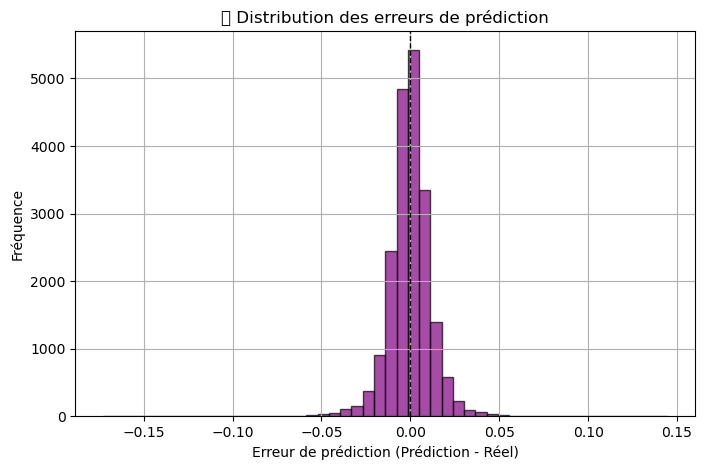

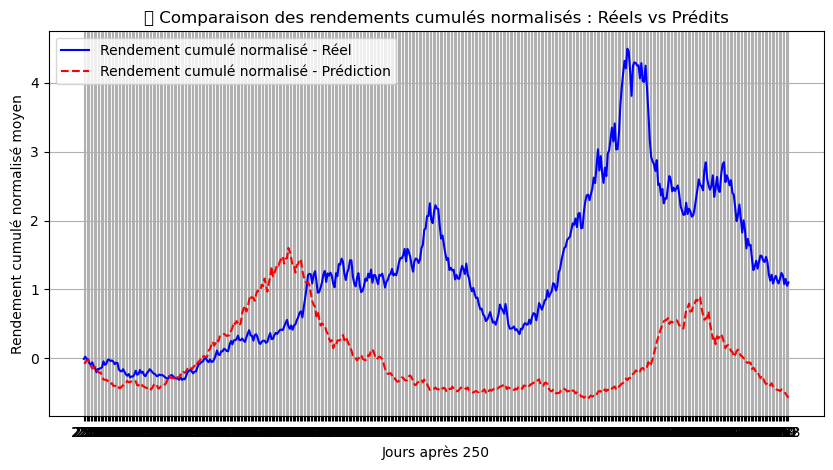

In [12]:
#Prediction du benchmark:

def predict_and_evaluate_classique(A, beta, X_train, Y_train):
    'Utilise les facteurs A et le vecteur beta pour pr√©dire les rendements futurs et √©value les performances du mod√®le.'
   
    D, F = A.shape  # Dimensions de A (D=250, F=nombre de facteurs)
    T = X_train.shape[1] # Nombre total de jours dans X_train
    T_pred = T - D  
    F_t = np.zeros((X_train.shape[0], T_pred, F))     # Initialisation de la matrice des facteurs 

    # Calcul des facteurs F 
    for t in range(T_pred):  # Iteration sur chaque 250 derni√®re valeur pour calculer les facteurs par actifs
        X_past = X_train.iloc[:, t:t+D].values  # Pour chaque actif, on r√©cup√®re les 250 jours pr√©c√©dents 
        F_t[:, t, :] = np.dot(X_past, A) # Calcul des facteurs pour chaque actif (40, 250) @ (250, F) -> (40, F)

    # Pr√©diction des rendements S_{t+1} = ‚àë Œ≤ * F_t
    Y_pred = np.einsum('ijk,k->ij', F_t, beta.flatten())  # Produit tensoriel (40, 504, F) @ (F,) -> (40, 504)
    Y_pred_df = pd.DataFrame(Y_pred, index=Y_train.index, columns=Y_train.columns)  # Conversion en DataFrame

    mse = mean_squared_error(Y_train.values.flatten(), Y_pred_df.values.flatten())  # Calcul du MSE
    correlation = np.corrcoef(Y_train.values.flatten(), Y_pred_df.values.flatten())[0, 1]  # Corr√©lation des valeurs

    # Affichage des r√©sultats
    print(f"üìä Performance du mod√®le :")
    print(f"‚úÖ Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : {correlation:.4f}")

    # üîπ Plot 1 : Moyenne des valeurs pr√©dites vs vraies valeurs
    plt.figure(figsize=(10, 5))
    plt.plot(Y_train.columns, Y_train.mean(axis=0), label="Vraies valeurs (moyenne)", color="blue")
    plt.plot(Y_train.columns, Y_pred_df.mean(axis=0), label="Pr√©dictions (moyenne)", color="red", linestyle="dashed")
    plt.xlabel("Jours apr√®s 250")
    plt.ylabel("Rendement moyen")
    plt.title("üìà Comparaison des rendements moyens : R√©els vs Pr√©dits")
    plt.legend()
    plt.grid()
    plt.show()

    # üîπ Plot 2 : Histogramme des erreurs
    errors = (Y_pred_df - Y_train).values.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel("Erreur de pr√©diction (Pr√©diction - R√©el)")
    plt.ylabel("Fr√©quence")
    plt.title("üìä Distribution des erreurs de pr√©diction")
    plt.grid()
    plt.show()

    # üîπ Plot 3 : Rendement cumul√© des pr√©dictions vs des vraies valeurs (moyenne)
    plt.figure(figsize=(10, 5))
    
    cumulative_real = (1 + Y_train.mean(axis=0)).cumprod() - 1
    cumulative_pred = (1 + Y_pred_df.mean(axis=0)).cumprod() - 1

    plt.plot(Y_train.columns, cumulative_real, label="Rendement cumul√© - R√©el", color="blue")
    plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumul√© - Pr√©diction", color="red", linestyle="dashed")
    plt.xlabel("Jours apr√®s 250")
    plt.ylabel("Rendement cumul√© moyen")
    plt.title("üìà Comparaison des rendements cumul√©s : R√©els vs Pr√©dits")
    plt.legend()
    plt.grid()
    plt.show()

    return mse, correlation


def predict_and_evaluate_avec_reshape(A, beta, Y_train):
    """
    Utilise les facteurs A et le vecteur beta pour pr√©dire les rendements futurs et √©value les performances du mod√®le.
    """

    # üîπ Calcul des facteurs en une seule √©tape (sans boucle)
    F_t = X_train_reshape @ A  # Produit matriciel direct (facteurs pour chaque actif)

    # üîπ Pr√©diction des rendements futurs
    Y_pred_df = (F_t @ beta).unstack().T  # Produit matriciel pour pr√©dire les rendements

    # üîπ Calcul des m√©triques
    mse = mean_squared_error(Y_train.values.flatten(), Y_pred_df.values.flatten())
    correlation = np.corrcoef(Y_train.values.flatten(), Y_pred_df.values.flatten())[0, 1]

    print(f"üìä Performance du mod√®le :")
    print(f"‚úÖ Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : {correlation:.4f}")

    # üîπ Plot 1 : Moyenne des valeurs pr√©dites vs vraies valeurs
    plt.figure(figsize=(10, 5))
    plt.plot(Y_train.columns, Y_train.mean(axis=0), label="Vraies valeurs (moyenne)", color="blue")
    plt.plot(Y_train.columns, Y_pred_df.mean(axis=0), label="Pr√©dictions (moyenne)", color="red", linestyle="dashed")
    plt.xlabel("Jours apr√®s 250")
    plt.ylabel("Rendement moyen")
    plt.title("üìà Comparaison des rendements moyens : R√©els vs Pr√©dits")
    plt.legend()
    plt.grid()
    plt.show()

    # üîπ Plot 2 : Histogramme des erreurs
    errors = (Y_pred_df - Y_train).values.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel("Erreur de pr√©diction (Pr√©diction - R√©el)")
    plt.ylabel("Fr√©quence")
    plt.title("üìä Distribution des erreurs de pr√©diction")
    plt.grid()
    plt.show()

    # üîπ Plot 3 : Rendement cumul√© des pr√©dictions vs des vraies valeurs (moyenne)
    plt.figure(figsize=(10, 5))
    
    cumulative_real = (1 + Y_train.mean(axis=0)).cumprod() - 1
    cumulative_pred = (1 + Y_pred_df.mean(axis=0)).cumprod() - 1

    plt.plot(Y_train.columns, cumulative_real, label="Rendement cumul√© - R√©el", color="blue")
    plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumul√© - Pr√©diction", color="red", linestyle="dashed")
    plt.xlabel("Jours apr√®s 250")
    plt.ylabel("Rendement cumul√© moyen")
    plt.title("üìà Comparaison des rendements cumul√©s : R√©els vs Pr√©dits")
    plt.legend()
    plt.grid()
    plt.show()


    return mse, correlation


def predict_and_evaluate_avec_normalisation(A, beta, Y_train):
    """
    Utilise les facteurs A et le vecteur beta pour pr√©dire les rendements futurs et √©value les performances du mod√®le.
    """

    # üîπ Calcul des facteurs en une seule √©tape (sans boucle)
    F_t = X_train_reshape @ A  # Produit matriciel direct (facteurs pour chaque actif)

    # üîπ Pr√©diction des rendements futurs
    Y_pred_df = (F_t @ beta).unstack().T  # Produit matriciel pour pr√©dire les rendements

    # üîπ Normalisation des matrices (comme dans `metric_train()`)
    Ytrue = Y_train.div(np.sqrt((Y_train**2).sum()), axis=1)    
    Ypred = Y_pred_df.div(np.sqrt((Y_pred_df**2).sum()), axis=1)

    # üîπ Calcul des m√©triques
    mse = mean_squared_error(Y_train.values.flatten(), Y_pred_df.values.flatten())
    correlation = np.corrcoef(Y_train.values.flatten(), Y_pred_df.values.flatten())[0, 1]

    print(f"üìä Performance du mod√®le :")
    print(f"‚úÖ Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : {correlation:.4f}")

    # üîπ Plot 1 : Moyenne des valeurs pr√©dites vs vraies valeurs (normalis√©es)
    plt.figure(figsize=(10, 5))
    plt.plot(Y_train.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalis√©es)", color="blue")
    plt.plot(Y_train.columns, Ypred.mean(axis=0), label="Pr√©dictions (normalis√©es)", color="red", linestyle="dashed")
    plt.xlabel("Jours apr√®s 250")
    plt.ylabel("Rendement normalis√© moyen")
    plt.title("üìà Comparaison des rendements normalis√©s : R√©els vs Pr√©dits")
    plt.legend()
    plt.grid()
    plt.show()

    # üîπ Plot 2 : Histogramme des erreurs (inchang√©)
    errors = (Y_pred_df - Y_train).values.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel("Erreur de pr√©diction (Pr√©diction - R√©el)")
    plt.ylabel("Fr√©quence")
    plt.title("üìä Distribution des erreurs de pr√©diction")
    plt.grid()
    plt.show()

    # üîπ Plot 3 : Rendements cumul√©s normalis√©s (au lieu des valeurs brutes)
    plt.figure(figsize=(10, 5))
    
    cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
    cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1

    plt.plot(Y_train.columns, cumulative_real, label="Rendement cumul√© normalis√© - R√©el", color="blue")
    plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumul√© normalis√© - Pr√©diction", color="red", linestyle="dashed")
    plt.xlabel("Jours apr√®s 250")
    plt.ylabel("Rendement cumul√© normalis√© moyen")
    plt.title("üìà Comparaison des rendements cumul√©s normalis√©s : R√©els vs Pr√©dits")
    plt.legend()
    plt.grid()
    plt.show()


    return mse, correlation





mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

Nos pr√©dictions bas√©es sur des facteurs g√©n√©r√©s al√©atoirement √©chouent √† capturer les dynamiques du march√©.
En effet, la structure al√©atoire des facteurs (moyenne =0) ne permet ni de capter les signaux financiers, ni de mod√©liser le bruit observ√© sur les march√©s.

# S√©lection des features


Nous travaillons sur des rendements financiers et avons s√©lectionn√© des features classiques issues de la litt√©rature financi√®re :

- **Momentum** : rendement cumul√© sur une fen√™tre d√©termin√©e, qui mesure la tendance d'un actif.
- **Volatility** : √©cart-type annualis√© des rendements sur une p√©riode donn√©e, indicateur de risque.
- **Moving average** : moyenne mobile des rendements, utile pour lisser les variations et identifier des tendances.
- **RSI (Relative Strength Index)** : indicateur de surachat ou de survente bas√© sur la force relative des gains et pertes r√©cents.

Nous appliquons une r√©gression : A modifier c'est ce que je faisais au d√©but
1. **R√©gression individuelle par actif** : chaque actif est mod√©lis√© s√©par√©ment avec ses propres features pour obtenir des coefficients sp√©cifiques.
2. **R√©gression globale** : les donn√©es sont agr√©g√©es dans un format long, permettant d'estimer des betas globaux communs √† l'ensemble des actifs.

Ces deux approches permettent d‚Äôanalyser les rendements sous diff√©rents angles et de comparer l‚Äôefficacit√© des mod√®les selon la granularit√© choisie.


Performance (metric_train): 0.03089
üìä Performance du mod√®le :
‚úÖ Erreur quadratique moyenne (MSE) : 0.000147
‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : 0.0380


/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


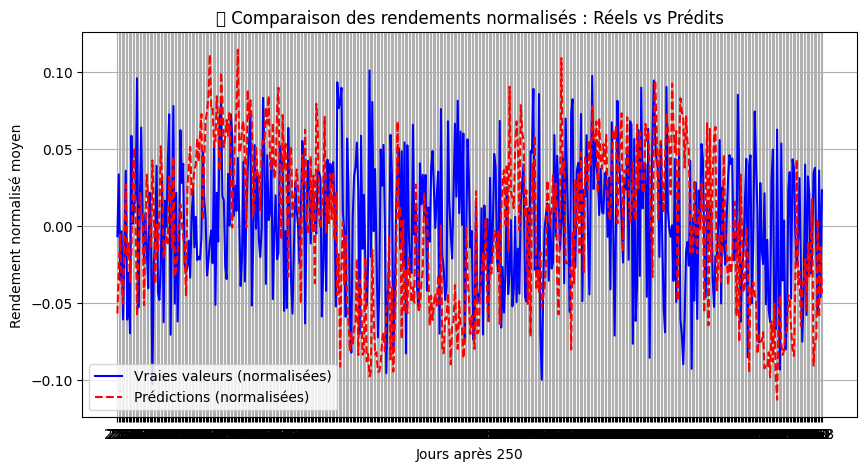

/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


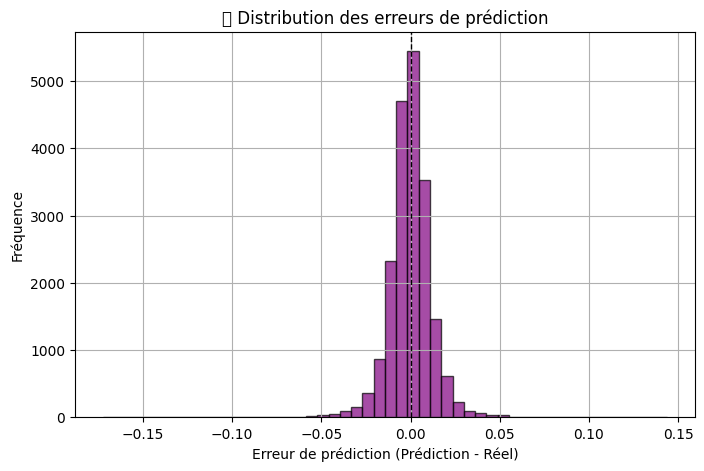

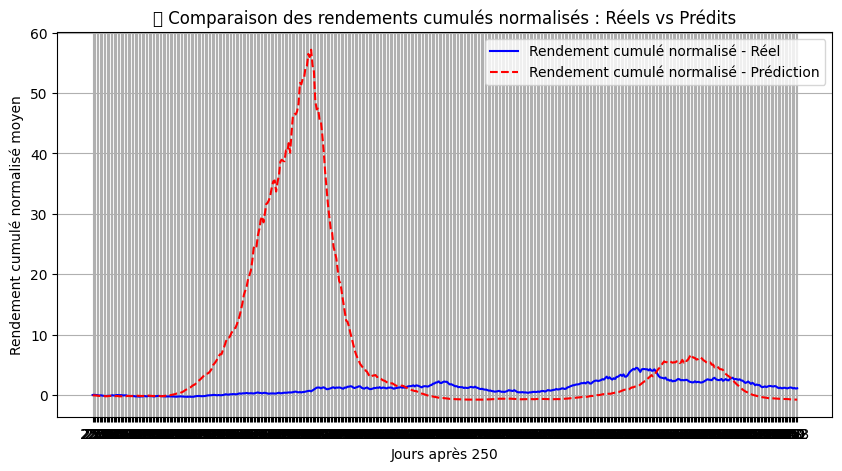

In [78]:

def compute_momentum(returns, window=21):
    """ Calcule le momentum comme rendement cumul√© sur la p√©riode donn√©e """
    return returns.rolling(window=window).sum()

def compute_volatility(returns, window=21):
    """ Calcule la volatilit√© r√©alis√©e """
    return returns.rolling(window=window).std()

def compute_moving_average(price, window=21):
    """ Calcule la moyenne mobile """
    ma = price.rolling(window=window).mean()
    return price - ma

def compute_rsi(price, window=14):
    """ Calcule l'indicateur RSI, indicateur de surachat ou de suvente """
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #Moyenne des rendements positifs (gains)
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() #Moyenne des rendement negatifs (pertes)
    rs = gain / loss
    return 100 - (100 / (1 + rs)) #Transformation du rs en score RSI (plus il est important plus c'est un signe de surachat et inversement)

def compute_z_score(series):
    """Calcule le z-score pour chaque s√©rie"""
    return (series - series.mean()) / series.std()


def generate_features(X_train):
    """ G√©n√®re les features et calcule un facteur unique pour chaque date """
    feature_dict = {}
    
    # Calcul des caract√©ristiques pour chaque actif
    for col in X_train.columns:
        # Calcul des caract√©ristiques : momentum, volatilit√©, moyenne mobile, et RSI
        feature_dict[f'momentum_{col}'] = compute_momentum(X_train[col])
        feature_dict[f'volatility_{col}'] = compute_volatility(X_train[col])
        feature_dict[f'moving_avg_{col}'] = compute_moving_average(X_train[col])
        feature_dict[f'rsi_{col}'] = compute_rsi(X_train[col])

    features = pd.concat(feature_dict, axis=1)  # On concat√®ne tout en une seule fois
    
    # Calcul des z-scores pour chaque caract√©ristique sur tous les actifs √† chaque date
    features_z = features.apply(compute_z_score, axis=0)  # Normalisation

    
    # Maintenant, pour chaque date, on calcule un facteur global (moyenne des z-scores)
    # pour chaque caract√©ristique
    factor_momentum = features_z.filter(like="momentum").mean(axis=1)  # Moyenne des z-scores du momentum
    factor_volatility = features_z.filter(like="volatility").mean(axis=1)  # Moyenne des z-scores de la volatilit√©
    factor_moving_avg = features_z.filter(like="moving_avg").mean(axis=1)  # Moyenne des z-scores de la moyenne mobile
    factor_rsi = features_z.filter(like="rsi").mean(axis=1)  # Moyenne des z-scores du RSI

    # DataFrame final avec un facteur pour chaque caract√©ristique √† chaque date
    final_features = pd.DataFrame({
        'momentum_factor': factor_momentum,
        'volatility_factor': factor_volatility,
        'moving_avg_factor': factor_moving_avg,
        'rsi_factor': factor_rsi
    })
    
    # Garde seulement les 250 premi√®res dates
    final_features = final_features.fillna(0)
    final_features = final_features.iloc[:250]
    
    return final_features


def A_Factors(D=250, F=10):
    factors = generate_features(X_train.T).values 
    
    # On normalise les 4 facteurs pour qu'ils soient orthonormaux
    A = np.zeros((D, F))
    for i in range(4):
        A[:, i] = factors[:, i] / np.linalg.norm(factors[:, i])

    A[:, :4] = scipy.linalg.orth(A[:, :4]) # Assure l'orthonormalit√©
    
    if F<=4:
        return A
    
    # # # G√©n√©ration des 6 autres colonnes orthonormales
    orthoProj = np.eye(D)
    for i in range(4):
        orthoProj -= np.outer(A[:, i], A[:, i])
    
    A_remaining_columns = orthoProj @ np.random.randn(D, F - 4)
    A_remaining_columns = scipy.linalg.orth(A_remaining_columns)  # Orthonormalisation

    A[:, 4:] = A_remaining_columns
    return A

# --- Pipeline principal ---
A = A_Factors()  # G√©n√©ration de A avec les 4 facteurs d√©finis
beta = fitBeta(A)  # Calcul de beta

# V√©rification de la m√©trique
metric_value = metric_train(A, beta)

# --- Affichage des r√©sultats ---
print(f"Performance (metric_train): {metric_value:.5f}")


mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)


#features = generate_features(X_train.T)
#features
#beta = compute_OLS(X_train.iloc[:, :250], Y_train, features)
#beta = fitBeta(features) #La meme regression que pour le benchmark, simplement avec moins de colonne dans features, mais ne fonctionne pas

#long_data = transform_to_long_format(features, X_train)
#betas_global, intercept_global = estimate_global_betas(long_data, long_data[['return']])
#betas_individual, intercepts_individual = estimate_individual_betas(features, X_train)

#m = metric_train(features, beta)




## Mod√®le non supervis√© (clustering)


- R√©duction de dimension avec PCA.
- D√©termination du meilleur K avec la m√©thode du coude :
    Analyser l'√©volution de l'inertie intra-classe en fonction du nombre de cluster. L'algoritmhe va partionner un ensemble de point en K groupes jusqu'a ce qu'un certain seuil de minimisation de l'inertie intra classe.
    L‚Äôinertie diminue forc√©ment quand on augmente ùêæ, mais apr√®s un certain point, l'am√©lioration devient n√©gligeable. Le "coude" est ce point optimal o√π l'ajout de clusters ne r√©duit plus significativement l'inertie.




- Application du clustering K-Means.
- √âvaluation et ajustement des hyperparam√®tres (optimisation avec GridSearchCV).

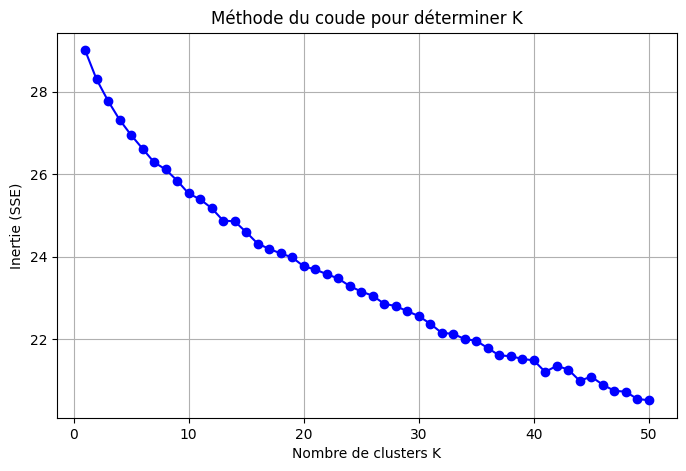

Meilleur mod√®le K-Means trouv√© avec K=26 et init='k-means++'
Performance du mod√®le : 0.05418
üìä Performance du mod√®le :
‚úÖ Erreur quadratique moyenne (MSE) : 0.000147
‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : 0.0623


/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


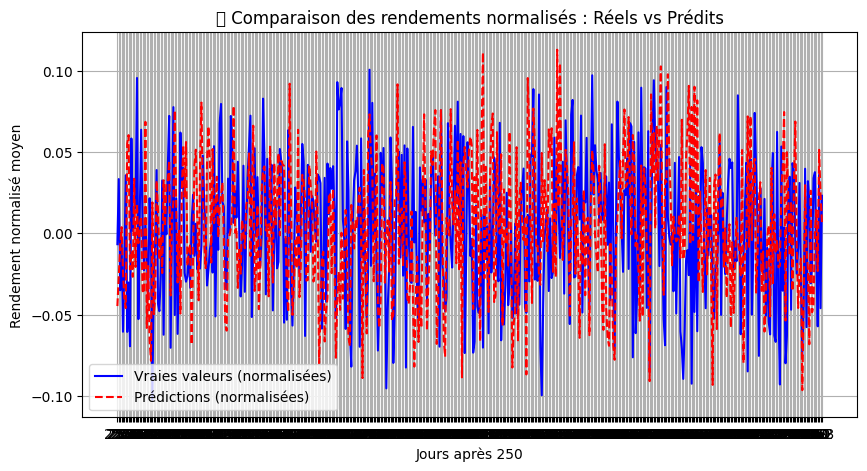

/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


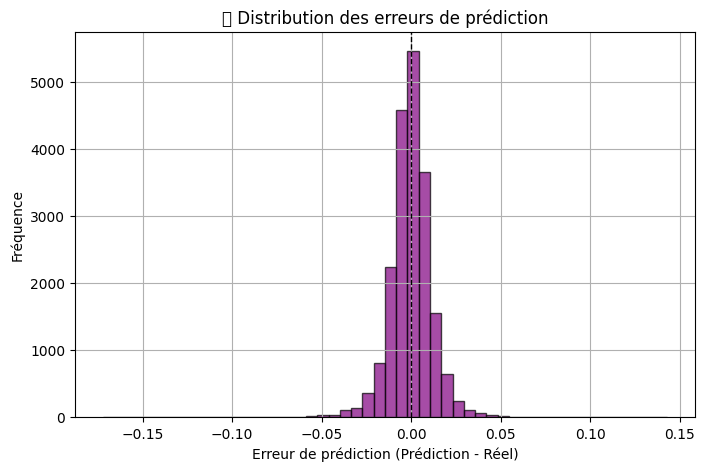

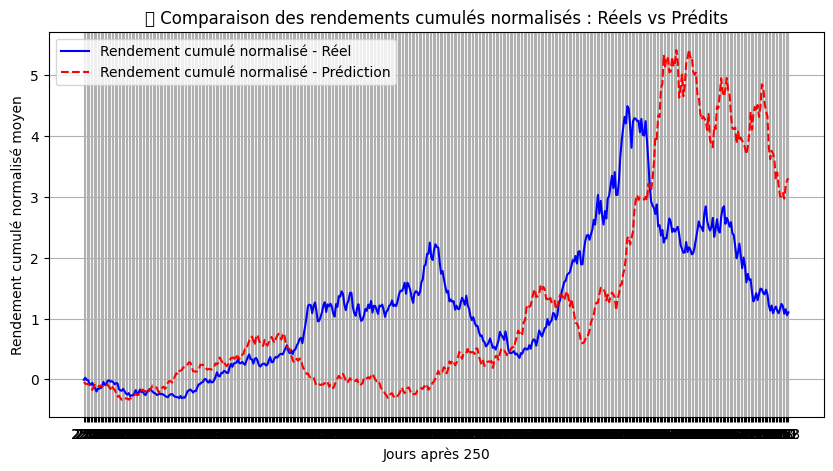

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def find_optimal_k_elbow(X, max_k=50):
    """Utilise la m√©thode du coude pour d√©terminer le nombre optimal de clusters."""
    
    inertias = [] #Vecteur pour stocker les valeurs d'inertie
    k_values = range(1, max_k + 1) #Valeurs de K √† tester
    
    #Boucle sur les valeurs de K pour calculer l'inertie
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Ex√©cute KMeans avec K clusters  et 10 initialisations des centroides et choisit la meilleure solution
        kmeans.fit(X)  # # Entraine le mod√®le sur les donn√©es de X
        inertias.append(kmeans.inertia_) #Stocke la valeur de l'inertie associ√© √† k
    
     # courbe du coude
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie (SSE)')
    plt.title('M√©thode du coude pour d√©terminer K')
    plt.grid(True)
    plt.show()
    
     # Demande √† l'utilisateur de choisir K, en fonction du point optimal sur le graphique, le "coude" ou la courbe commence √† s'aplatir
    k_optimal = int(input("Veuillez entrer la valeur optimale de K en fonction du graphique : "))
    return k_optimal

def apply_kmeans(X, k):
    """Applique K-Means et retourne les labels et le mod√®le KMeans."""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Initialisation du mod√®le KMeans
    labels = kmeans.fit_predict(X)   #entrainement du mod√®le et attribution des valeurs √† des clusters (labels)
    return labels, kmeans

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation crois√©e manuelle et retourne le meilleur mod√®le."""
    
    param_grid = {'n_clusters': [best_k-1, best_k, best_k+1], 'init': ['k-means++', 'random']}
    
    best_inertia = np.inf  
    best_model = None  

    # # Validation crois√©e manuelle avec KFold (3 folds ici, c'est a dire qu'on divise le dataset en 3, pour entrainer sur 2 folds et tester sur la 3eme)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    #Boucle pour parcourir chaque Hyperparam√®tres
    for n_clusters in param_grid['n_clusters']: #Parcours la liste de nombre de clusters qu'on souhaite tester (best_k-1, best_k, best_k+1)
        for init_method in param_grid['init']:#Parcours la liste des m√©thodes d'initialisation des centroides ('k-means++', 'random')
            avg_inertia = 0   # Initialisation de la variable d'inertie moyenne pour ces param√®tres

            # Boucle sur les splits de la validation crois√©e
            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx] # S√©pare les donn√©es en train et test
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10) #mod√®le KMeans avec les param√®tres de le boucle
                model.fit(X_train_fold)   #Entrainement du mod√®le sur le jeu d'entrainement
                avg_inertia += model.inertia_   # √âvalue l'inertie sur le jeu de test

            avg_inertia /= kf.get_n_splits()   # Moyenne des inerties sur tous les splits

            # Si l'inertie moyenne est meilleure (plus faible), on garde ce mod√®le
            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur mod√®le K-Means trouv√© avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """
    G√©n√®re la matrice A (250 jours, n_clusters) en utilisant les distances aux centro√Ødes.
    """
    centroids = best_cluster_model.cluster_centers_  # (n_clusters, d)


    X_pca = np.array(X_pca)  # Assure que c'est bien un tableau NumPy

    # V√©rification que les dimensions sont bien align√©es
    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilit√© des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    # Calcul des distances correctement align√©es
    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  

    # Extraction des 250 premi√®res lignes (jours)
    A = distances[:250, :]  # (250, n_clusters)

    A, _ = np.linalg.qr(A)  # Q est une matrice orthonormale


    return A

def compute_OLS(X_train, Y_train,features):
    predictors = X_train @ features
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements √† pr√©dire (apres 250) et les facteurs et les rendements actuels (de 0 √† 250)
    return beta.to_numpy()


# --- Pipeline principal ---
# 1. R√©duction de dimension avec PCA pour X_train.T (taille initiale (50, 754))
pca = PCA(n_components=0.95)  
x_pca = pca.fit_transform(X_train.T)  # Nouvelle taille (754, d)
x_pca, _ = np.linalg.qr(x_pca)

# 2. Trouver K optimal
best_k = find_optimal_k_elbow(x_pca)

# 3. Optimiser K-Means avec validation crois√©e
best_cluster_model = optimize_clustering(x_pca, best_k)

# 4. G√©n√©rer la matrice A (250 jours, n_clusters)
A = generate_factors_from_clusters(x_pca, best_cluster_model)

# 5. Effectuer la r√©gression
#beta = compute_OLS(X_train.iloc[:, :250].T, Y_train, A)
#beta = compute_OLS(X_train_reshape, Y_train, A)
beta = fitBeta(A)

# 6. Calculer la m√©trique de performance
metric_value = metric_train(A, beta)

print(f"Performance du mod√®le : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)




La m√©thode K-Means √©choue √† la pr√©vision des rendements financiers car elle est con√ßue pour segmenter des donn√©es en groupes homog√®nes et non pour pr√©dire des valeurs futures. Cette m√©thode minimise la variance intra-cluster, ce qui suppose implicitement que les clusters sont sph√©riques et de tailles similaires. Or, les rendements financiers sont hautement volatils et bruit√©s, ce qui emp√™che une s√©paration claire en groupes distincts. Ainsi, K-Means ne parvient pas √† capturer les dynamiques de march√© et √† produire des facteurs pertinents pour la pr√©diction.

## Mod√®le Supervis√© I : Boosting

XGBoost (Extreme Gradient Boosting) est un algorithme d‚Äôapprentissage supervis√© bas√© sur un ensemble d‚Äôarbres de d√©cision entra√Æn√©s s√©quentiellement. Contrairement √† un arbre de d√©cision classique qui effectue une seule pr√©diction, XGBoost ajoute progressivement plusieurs arbres, o√π chaque nouvel arbre est entra√Æn√© pour corriger les erreurs des arbres pr√©c√©dents.

Dans notre cas, XGBoost est utilis√© pour mod√©liser la relation entre les rendements pass√©s et les facteurs latents de march√©. Le mod√®le commence par un premier arbre qui fait une pr√©diction initiale des rendements futurs. Ensuite, un second arbre est entra√Æn√© pour pr√©dire les erreurs (r√©sidus) du premier, et ainsi de suite. √Ä la fin du processus, la pr√©diction finale est obtenue en combinant les pr√©dictions de tous les arbres.

Afin d‚Äôassurer la robustesse et la g√©n√©ralisation du mod√®le, nous mettons  en place une validation crois√©e manuelle (K-Fold Cross Validation). Cette technique consiste √† diviser le jeu de donn√©es en K sous-ensembles, et √† entra√Æner XGBoost K fois, en utilisant chaque fois K-1 sous-ensembles pour l‚Äôentra√Ænement et le dernier pour la validation. Cette approche permet de moyenner les performances du mod√®le sur plusieurs d√©coupages de donn√©es, √©vitant ainsi qu‚Äôil ne s‚Äôadapte trop fortement √† un seul jeu de donn√©es sp√©cifique (overfitting).

De plus, nous avons mis en place une optimisation des hyperparam√®tres afin de s√©lectionner les meilleures configurations du mod√®le. J‚Äôai utilis√© une recherche exhaustive (ParameterGrid), qui teste diff√©rentes combinaisons de param√®tres tels que :

Le nombre d‚Äôarbres (n_estimators) : Ajuste la complexit√© du mod√®le.
Le taux d‚Äôapprentissage (learning_rate) : Contr√¥le la vitesse d‚Äôadaptation du mod√®le.
La profondeur des arbres (max_depth) : D√©termine le niveau de d√©tail que chaque arbre peut capturer.
Le sous-√©chantillonnage (subsample) : R√©duit le risque d‚Äôoverfitting en utilisant une fraction des donn√©es √† chaque it√©ration.
Le nombre de caract√©ristiques utilis√©es (colsample_bytree) : S√©lectionne un sous-ensemble de variables √† chaque split d‚Äôun arbre.
Chaque combinaison d‚Äôhyperparam√®tres est √©valu√©e √† l‚Äôaide de la validation crois√©e, et le mod√®le ayant le meilleur score moyen est retenu. Pour √©viter d‚Äôentra√Æner des mod√®les inutiles, j‚Äôai aussi utilis√© early_stopping_rounds, qui stoppe l‚Äôentra√Ænement si le mod√®le ne s‚Äôam√©liore plus apr√®s un certain nombre d‚Äôit√©rations.

Enfin, apr√®s l‚Äôoptimisation, on extrais les facteurs de march√© en utilisant les valeurs des feuilles des arbres XGBoost, que je r√©duis avec PCA pour ne garder que les 10 facteurs les plus pertinents. Ces facteurs sont ensuite utilis√©s dans une r√©gression lin√©aire pour pr√©dire les rendements futurs.



In [10]:

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm  # Pour afficher la progression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# Permet d‚Äôafficher des messages de suivi √† chaque √©tape du programme.
def log(message):
    print(f"üîÑ {message}...")

# Pr√©paration des donn√©es
def prepare_data(X_train, Y_train):
    log("Pr√©paration des donn√©es")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

from sklearn.model_selection import KFold
import numpy as np

# Optimisation de XGBoost avec validation crois√©e manuelle
def optimize_xgboost(X_train, n_splits=3):
    log("Optimisation du mod√®le avec validation crois√©e manuelle")

    # üîπ D√©finition des hyperparam√®tres √† tester
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'learning_rate': [0.01, 0.1, 0.2],  
        'max_depth': [3, 5, 7],  
        'subsample': [0.8, 1],  
        'colsample_bytree': [0.8, 1]  
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    # üîπ Cr√©ation de la validation crois√©e (K-Fold)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # üîπ Boucle sur toutes les combinaisons d‚Äôhyperparam√®tres
    for params in tqdm(ParameterGrid(param_grid), desc="üîç Test d'hyperparam√®tres"):
        print(f"‚ñ∂Ô∏è Test : {params}")  # Affichage des hyperparam√®tres en direct

        scores = []

        # üîπ Validation crois√©e 
        for train_index, valid_index in kf.split(X_train):
            X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]

            # üîπ Cr√©ation du mod√®le avec les hyperparam√®tres actuels
            model = xgb.XGBRegressor(
                objective="reg:squarederror", 
                random_state=42, 
                verbosity=1,  
                early_stopping_rounds=10,  # Arr√™t anticip√© si pas d'am√©lioration
                **params
            )
            
            # üîπ Entra√Ænement avec le jeu de validation pour early stopping
            model.fit(X_train_split, X_train_split, eval_set=[(X_valid_split, X_valid_split)], verbose=False)

            # üîπ √âvaluation sur le jeu de validation
            score = model.score(X_valid_split, X_valid_split)
            scores.append(score)

        # üîπ Moyenne des scores de validation
        mean_score = np.mean(scores)

        # üîπ Mise √† jour du meilleur mod√®le
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"‚úÖ Meilleurs param√®tres trouv√©s : {best_params}")
    return best_model


# üîπ Extraction des facteurs apr√®s optimisation
def extract_factors_from_xgboost(model, X_train,n_factors=10):
    log("Extraction des facteurs √† partir de XGBoost")

    A_xgb = model.apply(X_train) # Extrait les valeurs des feuilles de chaque arbre comme nouveaux facteurs.

    # üîπ R√©duction avec PCA pour ne pas avoir trop de facteurs
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_xgb)  # (250, n_factors)

    A_reduced, _ = np.linalg.qr(A_reduced) # Orthonormalise les facteurs.
    return A_reduced


log("D√©but du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
xgb_best_model = optimize_xgboost(X_train_set)
A = extract_factors_from_xgboost(xgb_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du mod√®le : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("üéâ Processus termin√© !")


üîÑ D√©but du processus...
üîÑ Pr√©paration des donn√©es...
üîÑ Optimisation du mod√®le avec validation crois√©e manuelle...


üîç Test d'hyperparam√®tres:   0%|          | 0/108 [00:00<?, ?it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   1%|          | 1/108 [00:01<02:26,  1.37s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:   2%|‚ñè         | 2/108 [00:02<02:27,  1.39s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   3%|‚ñé         | 3/108 [00:05<03:18,  1.89s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:   4%|‚ñé         | 4/108 [00:07<03:40,  2.12s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   5%|‚ñç         | 5/108 [00:12<05:19,  3.10s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:   6%|‚ñå         | 6/108 [00:17<06:18,  3.71s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   6%|‚ñã         | 7/108 [00:20<05:55,  3.52s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:   7%|‚ñã         | 8/108 [00:23<05:36,  3.36s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   8%|‚ñä         | 9/108 [00:28<06:34,  3.98s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:   9%|‚ñâ         | 10/108 [00:34<07:28,  4.58s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  10%|‚ñà         | 11/108 [00:45<10:28,  6.47s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  11%|‚ñà         | 12/108 [00:56<12:27,  7.79s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  12%|‚ñà‚ñè        | 13/108 [00:59<10:13,  6.46s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  13%|‚ñà‚ñé        | 14/108 [01:03<08:54,  5.69s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  14%|‚ñà‚ñç        | 15/108 [01:10<09:26,  6.09s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  15%|‚ñà‚ñç        | 16/108 [01:18<10:09,  6.63s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  16%|‚ñà‚ñå        | 17/108 [01:31<12:59,  8.56s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  17%|‚ñà‚ñã        | 18/108 [01:47<15:54, 10.60s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  18%|‚ñà‚ñä        | 19/108 [01:48<11:37,  7.84s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  19%|‚ñà‚ñä        | 20/108 [01:49<08:37,  5.89s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  19%|‚ñà‚ñâ        | 21/108 [01:52<06:56,  4.78s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  20%|‚ñà‚ñà        | 22/108 [01:54<05:40,  3.96s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  21%|‚ñà‚ñà‚ñè       | 23/108 [01:56<05:07,  3.61s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  22%|‚ñà‚ñà‚ñè       | 24/108 [01:58<04:22,  3.13s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  23%|‚ñà‚ñà‚ñé       | 25/108 [02:01<04:00,  2.90s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  24%|‚ñà‚ñà‚ñç       | 26/108 [02:03<03:48,  2.79s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  25%|‚ñà‚ñà‚ñå       | 27/108 [02:06<03:52,  2.87s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  26%|‚ñà‚ñà‚ñå       | 28/108 [02:09<03:55,  2.95s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  27%|‚ñà‚ñà‚ñã       | 29/108 [02:13<04:04,  3.09s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  28%|‚ñà‚ñà‚ñä       | 30/108 [02:16<03:59,  3.07s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  29%|‚ñà‚ñà‚ñä       | 31/108 [02:19<03:50,  2.99s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  30%|‚ñà‚ñà‚ñâ       | 32/108 [02:22<03:43,  2.94s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  31%|‚ñà‚ñà‚ñà       | 33/108 [02:25<03:55,  3.15s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  31%|‚ñà‚ñà‚ñà‚ñè      | 34/108 [02:28<03:57,  3.21s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  32%|‚ñà‚ñà‚ñà‚ñè      | 35/108 [02:32<04:10,  3.43s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  33%|‚ñà‚ñà‚ñà‚ñé      | 36/108 [02:36<04:03,  3.39s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  34%|‚ñà‚ñà‚ñà‚ñç      | 37/108 [02:37<03:11,  2.70s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  35%|‚ñà‚ñà‚ñà‚ñå      | 38/108 [02:38<02:33,  2.20s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  36%|‚ñà‚ñà‚ñà‚ñå      | 39/108 [02:39<02:18,  2.01s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  37%|‚ñà‚ñà‚ñà‚ñã      | 40/108 [02:41<01:57,  1.73s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  38%|‚ñà‚ñà‚ñà‚ñä      | 41/108 [02:42<01:54,  1.71s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  39%|‚ñà‚ñà‚ñà‚ñâ      | 42/108 [02:43<01:40,  1.53s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  40%|‚ñà‚ñà‚ñà‚ñâ      | 43/108 [02:45<01:44,  1.61s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  41%|‚ñà‚ñà‚ñà‚ñà      | 44/108 [02:47<01:43,  1.62s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 45/108 [02:49<01:49,  1.73s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 46/108 [02:50<01:45,  1.71s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 47/108 [02:52<01:48,  1.78s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 48/108 [02:54<01:43,  1.72s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 49/108 [02:56<01:45,  1.79s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 50/108 [02:58<01:43,  1.79s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 51/108 [03:00<01:50,  1.94s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 52/108 [03:02<01:47,  1.92s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 53/108 [03:04<01:52,  2.05s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 54/108 [03:06<01:45,  1.96s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 55/108 [03:07<01:35,  1.81s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 56/108 [03:09<01:28,  1.70s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 57/108 [03:12<01:42,  2.02s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 58/108 [03:14<01:52,  2.25s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 59/108 [03:20<02:36,  3.20s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 60/108 [03:25<03:05,  3.85s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 61/108 [03:28<02:50,  3.63s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 62/108 [03:32<02:41,  3.52s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 63/108 [03:37<03:09,  4.21s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 64/108 [03:44<03:35,  4.90s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 65/108 [03:57<05:15,  7.33s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 66/108 [04:10<06:26,  9.19s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 67/108 [04:16<05:28,  8.02s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 68/108 [04:20<04:32,  6.81s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 69/108 [04:26<04:21,  6.70s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 70/108 [04:33<04:15,  6.73s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 71/108 [04:45<05:04,  8.22s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 72/108 [04:59<06:05, 10.15s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 73/108 [05:01<04:24,  7.56s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 74/108 [05:02<03:16,  5.77s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 75/108 [05:04<02:32,  4.63s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 76/108 [05:06<01:59,  3.74s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 77/108 [05:08<01:38,  3.19s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 78/108 [05:10<01:22,  2.74s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 79/108 [05:12<01:16,  2.64s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 80/108 [05:15<01:13,  2.62s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 81/108 [05:18<01:15,  2.79s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 82/108 [05:22<01:20,  3.09s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 83/108 [05:25<01:17,  3.08s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 84/108 [05:28<01:14,  3.08s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 85/108 [05:31<01:09,  3.00s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 86/108 [05:33<01:03,  2.90s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 87/108 [05:36<01:00,  2.87s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 88/108 [05:39<00:57,  2.88s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 89/108 [05:42<00:54,  2.86s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 90/108 [05:45<00:53,  2.96s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 91/108 [05:46<00:40,  2.39s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 92/108 [05:47<00:31,  1.98s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 93/108 [05:48<00:26,  1.79s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 94/108 [05:49<00:22,  1.59s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 95/108 [05:51<00:19,  1.53s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 96/108 [05:52<00:16,  1.38s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 97/108 [05:53<00:16,  1.46s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 98/108 [05:55<00:15,  1.52s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 99/108 [05:57<00:13,  1.52s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 100/108 [05:58<00:11,  1.50s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 101/108 [06:00<00:10,  1.53s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 102/108 [06:01<00:09,  1.53s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 103/108 [06:03<00:07,  1.53s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 104/108 [06:04<00:06,  1.54s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 105/108 [06:06<00:04,  1.55s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 106/108 [06:07<00:03,  1.54s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 107/108 [06:09<00:01,  1.56s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 108/108 [06:11<00:00,  3.44s/it]


‚úÖ Meilleurs param√®tres trouv√©s : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
üîÑ Extraction des facteurs √† partir de XGBoost...
(250, 10)
Performance du mod√®le : 0.01818


NameError: name 'predict_and_evaluate' is not defined

üîÑ D√©but du processus...
üîÑ Pr√©paration des donn√©es...
üîÑ Optimisation du mod√®le avec validation crois√©e manuelle...


üîç Test d'hyperparam√®tres:   0%|          | 0/108 [00:00<?, ?it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   1%|          | 1/108 [00:00<00:47,  2.23it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:   2%|‚ñè         | 2/108 [00:00<00:40,  2.64it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   3%|‚ñé         | 3/108 [00:01<00:40,  2.57it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:   4%|‚ñé         | 4/108 [00:01<00:41,  2.53it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   5%|‚ñç         | 5/108 [00:01<00:40,  2.52it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:   6%|‚ñå         | 6/108 [00:02<00:40,  2.55it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   6%|‚ñã         | 7/108 [00:03<00:55,  1.83it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:   7%|‚ñã         | 8/108 [00:03<01:01,  1.64it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:   8%|‚ñä         | 9/108 [00:04<01:08,  1.44it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:   9%|‚ñâ         | 10/108 [00:05<01:10,  1.39it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  10%|‚ñà         | 11/108 [00:06<01:14,  1.30it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  11%|‚ñà         | 12/108 [00:07<01:12,  1.32it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  12%|‚ñà‚ñè        | 13/108 [00:08<01:32,  1.03it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  13%|‚ñà‚ñé        | 14/108 [00:10<01:44,  1.11s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  14%|‚ñà‚ñç        | 15/108 [00:11<01:55,  1.24s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  15%|‚ñà‚ñç        | 16/108 [00:13<02:00,  1.31s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  16%|‚ñà‚ñå        | 17/108 [00:14<02:03,  1.36s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  17%|‚ñà‚ñã        | 18/108 [00:16<02:04,  1.39s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  18%|‚ñà‚ñä        | 19/108 [00:16<01:35,  1.07s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  19%|‚ñà‚ñä        | 20/108 [00:16<01:15,  1.16it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  19%|‚ñà‚ñâ        | 21/108 [00:17<01:02,  1.40it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  20%|‚ñà‚ñà        | 22/108 [00:17<00:53,  1.61it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  21%|‚ñà‚ñà‚ñè       | 23/108 [00:17<00:46,  1.81it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  22%|‚ñà‚ñà‚ñè       | 24/108 [00:18<00:40,  2.06it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  23%|‚ñà‚ñà‚ñé       | 25/108 [00:19<00:47,  1.74it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  24%|‚ñà‚ñà‚ñç       | 26/108 [00:19<00:51,  1.58it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  25%|‚ñà‚ñà‚ñå       | 27/108 [00:20<00:52,  1.54it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  26%|‚ñà‚ñà‚ñå       | 28/108 [00:21<00:54,  1.47it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  27%|‚ñà‚ñà‚ñã       | 29/108 [00:22<00:55,  1.43it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  28%|‚ñà‚ñà‚ñä       | 30/108 [00:22<00:55,  1.41it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  29%|‚ñà‚ñà‚ñä       | 31/108 [00:23<01:06,  1.16it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  30%|‚ñà‚ñà‚ñâ       | 32/108 [00:25<01:17,  1.02s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  31%|‚ñà‚ñà‚ñà       | 33/108 [00:26<01:23,  1.11s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  31%|‚ñà‚ñà‚ñà‚ñè      | 34/108 [00:28<01:31,  1.24s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  32%|‚ñà‚ñà‚ñà‚ñè      | 35/108 [00:29<01:32,  1.26s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  33%|‚ñà‚ñà‚ñà‚ñé      | 36/108 [00:30<01:33,  1.30s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  34%|‚ñà‚ñà‚ñà‚ñç      | 37/108 [00:31<01:11,  1.01s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  35%|‚ñà‚ñà‚ñà‚ñå      | 38/108 [00:31<00:58,  1.20it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  36%|‚ñà‚ñà‚ñà‚ñå      | 39/108 [00:32<00:51,  1.34it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  37%|‚ñà‚ñà‚ñà‚ñã      | 40/108 [00:32<00:42,  1.59it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  38%|‚ñà‚ñà‚ñà‚ñä      | 41/108 [00:32<00:37,  1.80it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  39%|‚ñà‚ñà‚ñà‚ñâ      | 42/108 [00:33<00:32,  2.03it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  40%|‚ñà‚ñà‚ñà‚ñâ      | 43/108 [00:34<00:36,  1.76it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  41%|‚ñà‚ñà‚ñà‚ñà      | 44/108 [00:34<00:40,  1.59it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 45/108 [00:35<00:41,  1.52it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 46/108 [00:36<00:42,  1.45it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  44%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 47/108 [00:36<00:41,  1.46it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 48/108 [00:37<00:42,  1.42it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 49/108 [00:38<00:49,  1.20it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  46%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 50/108 [00:40<00:55,  1.05it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 51/108 [00:41<00:57,  1.01s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 52/108 [00:42<01:00,  1.08s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 53/108 [00:43<01:02,  1.14s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 54/108 [00:45<01:05,  1.22s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 55/108 [00:45<00:53,  1.00s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 56/108 [00:46<00:41,  1.24it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 57/108 [00:46<00:36,  1.41it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 58/108 [00:46<00:30,  1.66it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 59/108 [00:47<00:27,  1.79it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 60/108 [00:47<00:24,  1.98it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 61/108 [00:48<00:30,  1.56it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 62/108 [00:49<00:31,  1.45it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 63/108 [00:50<00:33,  1.36it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 64/108 [00:51<00:33,  1.33it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 65/108 [00:51<00:34,  1.26it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 66/108 [00:52<00:33,  1.26it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 67/108 [00:54<00:43,  1.07s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 68/108 [00:56<00:49,  1.24s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 69/108 [00:57<00:51,  1.33s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 70/108 [00:59<00:52,  1.39s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 71/108 [01:00<00:54,  1.47s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 72/108 [01:02<00:53,  1.50s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 73/108 [01:02<00:40,  1.16s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 74/108 [01:03<00:31,  1.07it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 75/108 [01:03<00:24,  1.32it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 76/108 [01:03<00:20,  1.55it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 77/108 [01:04<00:17,  1.80it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 78/108 [01:04<00:14,  2.03it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 79/108 [01:05<00:17,  1.65it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 80/108 [01:06<00:18,  1.51it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 81/108 [01:07<00:19,  1.41it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 82/108 [01:07<00:19,  1.34it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 83/108 [01:08<00:19,  1.30it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 84/108 [01:09<00:18,  1.29it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 85/108 [01:10<00:22,  1.04it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 86/108 [01:12<00:24,  1.13s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 87/108 [01:14<00:27,  1.31s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 88/108 [01:16<00:29,  1.46s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 89/108 [01:17<00:29,  1.56s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 90/108 [01:19<00:28,  1.60s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 91/108 [01:20<00:21,  1.28s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 92/108 [01:20<00:16,  1.04s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 93/108 [01:20<00:12,  1.18it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 94/108 [01:21<00:09,  1.41it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 95/108 [01:21<00:08,  1.55it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 96/108 [01:22<00:06,  1.77it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 97/108 [01:23<00:07,  1.52it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 98/108 [01:24<00:08,  1.21it/s]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 99/108 [01:26<00:11,  1.28s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 100/108 [01:27<00:09,  1.21s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 101/108 [01:28<00:08,  1.17s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 102/108 [01:29<00:06,  1.09s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 103/108 [01:31<00:06,  1.25s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


üîç Test d'hyperparam√®tres:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 104/108 [01:32<00:05,  1.36s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 105/108 [01:34<00:04,  1.44s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


üîç Test d'hyperparam√®tres:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 106/108 [01:36<00:03,  1.59s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


üîç Test d'hyperparam√®tres:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 107/108 [01:38<00:01,  1.59s/it]

‚ñ∂Ô∏è Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


üîç Test d'hyperparam√®tres: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 108/108 [01:39<00:00,  1.08it/s]
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


‚úÖ Meilleurs param√®tres trouv√©s : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
üîÑ Extraction des facteurs √† partir de XGBoost...
(250, 10)
Performance du mod√®le : 0.04038
üìä Performance du mod√®le :
‚úÖ Erreur quadratique moyenne (MSE) : 0.000147
‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : 0.0437


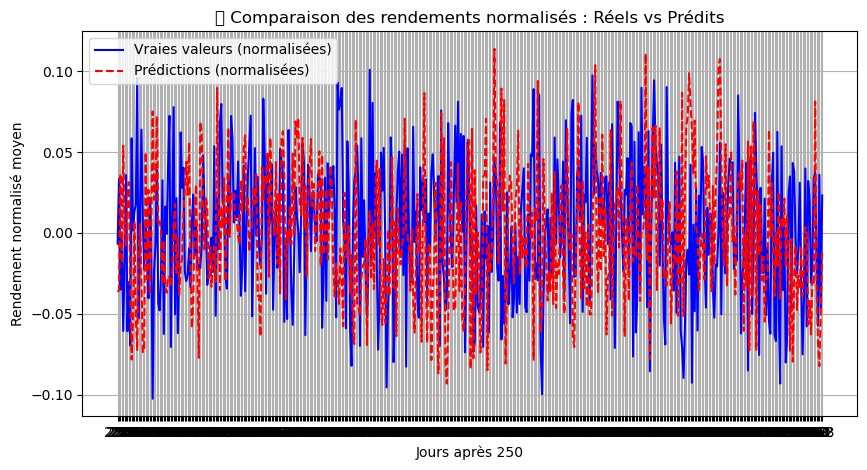

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


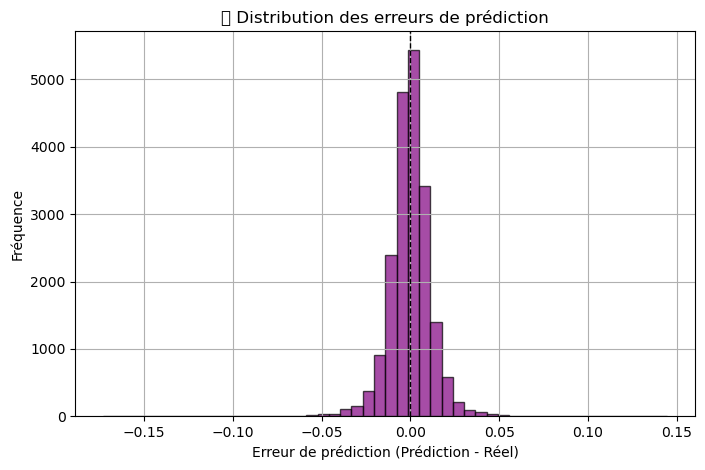

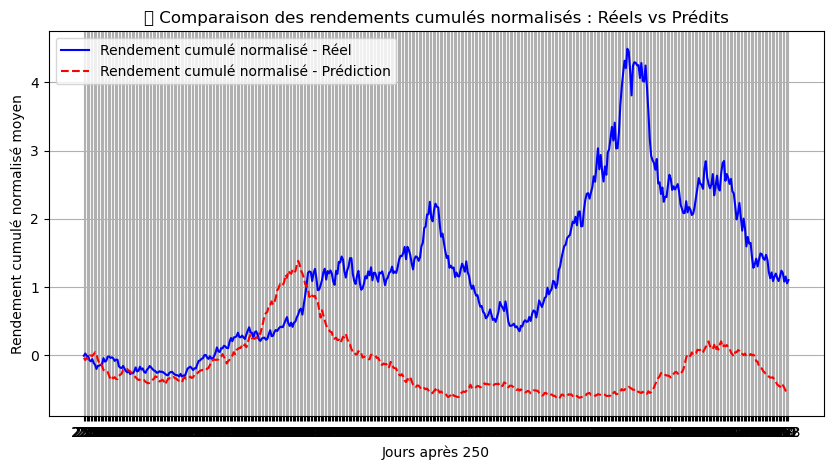

üîÑ üéâ Processus termin√© !...


In [26]:
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm  # Pour afficher la progression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# Permet d‚Äôafficher des messages de suivi √† chaque √©tape du programme.
def log(message):
    print(f"üîÑ {message}...")

# Pr√©paration des donn√©es
def prepare_data(X_train, Y_train):
    log("Pr√©paration des donn√©es")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

from sklearn.model_selection import KFold
import numpy as np

import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# üîπ Fonction pour afficher des logs
def log(message):
    print(f"üîÑ {message}...")

# üîπ Optimisation de XGBoost avec validation crois√©e manuelle
def optimize_xgboost(X_train, Y_train, n_splits=3):
    log("Optimisation du mod√®le avec validation crois√©e manuelle")

    # üîπ D√©finition des hyperparam√®tres √† tester
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'learning_rate': [0.01, 0.1, 0.2],  
        'max_depth': [3, 5, 7],  
        'subsample': [0.8, 1],  
        'colsample_bytree': [0.8, 1]  
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    # üîπ Cr√©ation de la validation crois√©e (K-Fold)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # üîπ Boucle sur toutes les combinaisons d‚Äôhyperparam√®tres
    for params in tqdm(ParameterGrid(param_grid), desc="üîç Test d'hyperparam√®tres"):
        print(f"‚ñ∂Ô∏è Test : {params}")  # Affichage des hyperparam√®tres en direct

        scores = []

        # üîπ Validation crois√©e 
        for train_index, valid_index in kf.split(X_train):
            X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
            Y_train_split, Y_valid_split = Y_train.iloc[train_index], Y_train.iloc[valid_index]

            # üîπ Cr√©ation du mod√®le avec les hyperparam√®tres actuels
            model = xgb.XGBRegressor(
                objective="reg:squarederror", 
                random_state=42, 
                verbosity=1,  
                eval_metric="rmse",  # Pour que early_stopping fonctionne
                early_stopping_rounds=10,  # Arr√™t anticip√© si pas d'am√©lioration
                **params
            )
            
            # üîπ Entra√Ænement avec le jeu de validation pour early stopping
            model.fit(
                X_train_split, Y_train_split,  
                eval_set=[(X_valid_split, Y_valid_split)],  
                verbose=False
            )

            # üîπ √âvaluation sur le jeu de validation
            score = mean_squared_error(Y_valid_split, model.predict(X_valid_split))
            scores.append(score)

        # üîπ Moyenne des scores de validation
        mean_score = np.mean(scores)

        # üîπ Mise √† jour du meilleur mod√®le
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"‚úÖ Meilleurs param√®tres trouv√©s : {best_params}")
    return best_model



# üîπ Extraction des facteurs apr√®s optimisation
def extract_factors_from_xgboost(model, X_train,n_factors=10):
    log("Extraction des facteurs √† partir de XGBoost")

    A_xgb = model.apply(X_train) # Extrait les valeurs des feuilles de chaque arbre comme nouveaux facteurs.

    # üîπ R√©duction avec PCA pour ne pas avoir trop de facteurs
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_xgb)  # (250, n_factors)

    A_reduced, _ = np.linalg.qr(A_reduced) # Orthonormalise les facteurs.
    return A_reduced


log("D√©but du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
xgb_best_model = optimize_xgboost(X_train_set,Y_train_set)
A = extract_factors_from_xgboost(xgb_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du mod√®le : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("üéâ Processus termin√© !")


## Mod√®le Supervis√© II : Bagging
Le Bagging (Bootstrap Aggregating) est une m√©thode d‚Äôensemble qui entra√Æne plusieurs mod√®les ind√©pendants sur des √©chantillons bootstrap des donn√©es. Contrairement au Boosting, qui corrige it√©rativement les erreurs des mod√®les pr√©c√©dents, le Bagging entra√Æne ses mod√®les en parall√®le et moyenne leurs pr√©dictions pour r√©duire la variance.

Dans notre cas, Bagging est utilis√© pour mod√©liser la relation entre les rendements pass√©s et les facteurs latents de march√©. Chaque mod√®le du Bagging est un arbre de d√©cision, entra√Æn√© sur des sous-√©chantillons des donn√©es. L‚Äôobjectif est d‚Äôobtenir un mod√®le robuste, r√©duisant la variance tout en capturant des structures complexes dans les donn√©es.

Afin d‚Äôassurer la robustesse et la g√©n√©ralisation du mod√®le, nous utilisons une validation crois√©e (K-Fold Cross Validation). Cette technique permet d‚Äô√©valuer la stabilit√© du mod√®le en testant plusieurs d√©coupages des donn√©es.
Nous optimisons √©galement les hyperparam√®tres via une recherche sur grille (ParameterGrid), en testant diff√©rentes valeurs de :

n_estimators : Nombre d‚Äôarbres dans le mod√®le Bagging.
max_samples : Proportion de l‚Äô√©chantillon utilis√©e par chaque arbre.
max_features : Nombre de variables utilis√©es pour chaque mod√®le.
Enfin, apr√®s l‚Äôoptimisation, nous extrayons les facteurs de march√© en utilisant les pr√©dictions des mod√®les entra√Æn√©s, puis nous appliquons une r√©duction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.


üîÑ D√©but du processus...
üîÑ Pr√©paration des donn√©es...
üîÑ Optimisation du mod√®le avec validation crois√©e K-Fold...


üîç Test d'hyperparam√®tres:   0%|          | 0/27 [00:00<?, ?it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:   4%|‚ñé         | 1/27 [00:00<00:11,  2.19it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:   7%|‚ñã         | 2/27 [00:01<00:16,  1.54it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  11%|‚ñà         | 3/27 [00:02<00:26,  1.09s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  15%|‚ñà‚ñç        | 4/27 [00:03<00:19,  1.19it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  19%|‚ñà‚ñä        | 5/27 [00:04<00:19,  1.14it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  22%|‚ñà‚ñà‚ñè       | 6/27 [00:06<00:25,  1.20s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  26%|‚ñà‚ñà‚ñå       | 7/27 [00:06<00:19,  1.01it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  30%|‚ñà‚ñà‚ñâ       | 8/27 [00:07<00:19,  1.03s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  33%|‚ñà‚ñà‚ñà‚ñé      | 9/27 [00:09<00:24,  1.37s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  37%|‚ñà‚ñà‚ñà‚ñã      | 10/27 [00:10<00:18,  1.10s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  41%|‚ñà‚ñà‚ñà‚ñà      | 11/27 [00:11<00:16,  1.05s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 12/27 [00:13<00:19,  1.30s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 13/27 [00:13<00:14,  1.07s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 14/27 [00:14<00:14,  1.08s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 15/27 [00:17<00:16,  1.41s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 16/27 [00:17<00:13,  1.19s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 17/27 [00:19<00:12,  1.27s/it]

‚ñ∂Ô∏è Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 18/27 [00:21<00:15,  1.68s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 19/27 [00:22<00:10,  1.34s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 20/27 [00:23<00:08,  1.27s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 21/27 [00:25<00:09,  1.53s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 22/27 [00:26<00:06,  1.27s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 23/27 [00:27<00:05,  1.35s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 24/27 [00:30<00:05,  1.75s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 25/27 [00:31<00:02,  1.48s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 26/27 [00:33<00:01,  1.56s/it]

‚ñ∂Ô∏è Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


üîç Test d'hyperparam√®tres: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 27/27 [00:36<00:00,  1.35s/it]

‚úÖ Meilleurs param√®tres trouv√©s : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}
üîÑ Extraction des facteurs √† partir de Bagging...


(250, 10)
Performance du mod√®le : 0.02757
üìä Performance du mod√®le :
‚úÖ Erreur quadratique moyenne (MSE) : 0.000147
‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : 0.0350


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


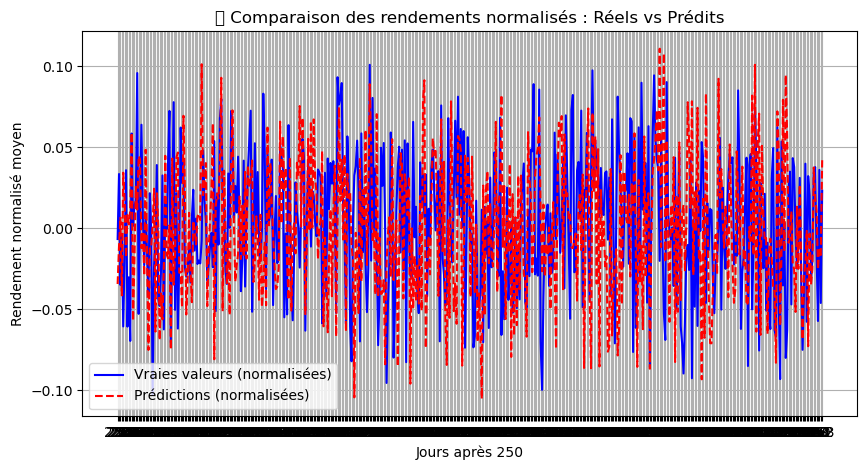

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


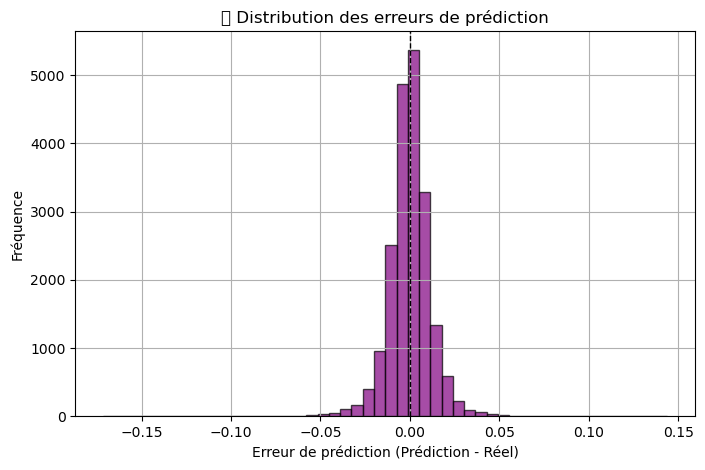

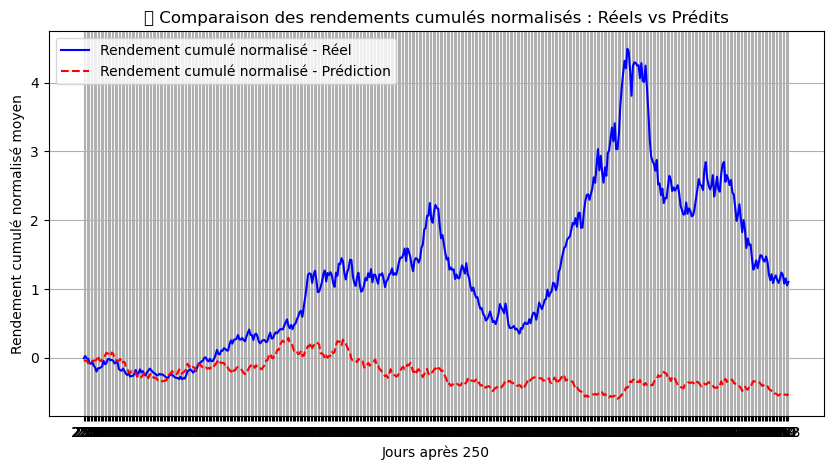

üîÑ üéâ Processus termin√© !...


In [34]:
import numpy as np
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # Pour afficher la progression

# üîπ Fonction pour afficher des logs
def log(message):
    print(f"üîÑ {message}...")

# üîπ Pr√©paration des donn√©es
def prepare_data(X_train, Y_train):
    log("Pr√©paration des donn√©es")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

# üîπ Optimisation du mod√®le Bagging avec validation crois√©e (K-Fold)
def optimize_bagging(X_train, Y_train, n_splits=3):
    log("Optimisation du mod√®le avec validation crois√©e K-Fold")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_samples': [0.5, 0.7, 1.0],  # √âchantillonnage bootstrap
        'max_features': [0.5, 0.7, 1.0]  # S√©lection al√©atoire de features
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # üîπ Test de toutes les combinaisons d‚Äôhyperparam√®tres
    for params in tqdm(ParameterGrid(param_grid), desc="üîç Test d'hyperparam√®tres"):
        print(f"‚ñ∂Ô∏è Test : {params}")

        scores = []

        # üîπ Validation crois√©e (K-Fold)
        for train_index, valid_index in kf.split(X_train):
            X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
            Y_train_split, Y_valid_split = Y_train.iloc[train_index], Y_train.iloc[valid_index]

            # üîπ Cr√©ation du mod√®le avec les hyperparam√®tres actuels
            model = BaggingRegressor(
                estimator=DecisionTreeRegressor(),
                random_state=42,
                **params
            )

            # üîπ Entra√Ænement sur l‚Äôensemble d‚Äôapprentissage
            model.fit(X_train_split, Y_train_split)

            # üîπ Pr√©diction et √©valuation
            score = mean_squared_error(Y_valid_split, model.predict(X_valid_split))
            scores.append(score)

        mean_score = np.mean(scores)

        # üîπ Mise √† jour du meilleur mod√®le
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"‚úÖ Meilleurs param√®tres trouv√©s : {best_params}")
    return best_model

# üîπ Extraction des facteurs via Bagging et r√©duction avec PCA
def extract_factors_from_bagging(model, X_train, n_factors=10):
    log("Extraction des facteurs √† partir de Bagging")

    A_bagging = model.predict(X_train)  # On prend les pr√©dictions comme nouveaux facteurs

    # üîπ R√©duction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_bagging)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

# üîπ Entra√Ænement et √©valuation du mod√®le
log("D√©but du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
bagging_best_model = optimize_bagging(X_train_set, Y_train_set)
A = extract_factors_from_bagging(bagging_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du mod√®le : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("üéâ Processus termin√© !")


In [40]:
# Utilisation du OOB Score plutot que CV-Kfold mais soucis de dimension entre X Train & Y Train
import numpy as np
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # Pour afficher la progression

# üîπ Fonction pour afficher des logs
def log(message):
    print(f"üîÑ {message}...")

# üîπ Pr√©paration des donn√©es
def prepare_data(X_train, Y_train):
    log("Pr√©paration des donn√©es")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

# üîπ Optimisation du mod√®le Bagging en utilisant OOB Score
def optimize_bagging_oob(X_train,Y_train):
    log("Optimisation du mod√®le avec OOB Score")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_samples': [0.5, 0.7, 1.0],  # Pourcentage de l'√©chantillon utilis√© par chaque arbre
        'max_features': [0.5, 0.7, 1.0]  # Proportion des features utilis√©es
    }

    best_model = None
    best_oob_score = float('-inf')  # OOB Score doit √™tre maximis√©
    best_params = None

    for params in tqdm(ParameterGrid(param_grid), desc="üîç Test d'hyperparam√®tres"):
        print(f"‚ñ∂Ô∏è Test : {params}")

        # üîπ Cr√©ation du mod√®le avec les param√®tres actuels
        model = BaggingRegressor(
            estimator=DecisionTreeRegressor(),
            oob_score=True,  # Activation du OOB Score
            random_state=42,
            **params
        )

        model.fit(X_train, Y_train)  # Pas de validation crois√©e ici, OOB g√®re √ßa

        # üîπ R√©cup√©ration du OOB Score
        oob_score = model.oob_score_

        if oob_score > best_oob_score:  # On veut maximiser le OOB Score
            best_oob_score = oob_score
            best_model = model
            best_params = params

    print(f"‚úÖ Meilleurs param√®tres trouv√©s : {best_params} avec OOB Score = {best_oob_score:.4f}")
    return best_model

# üîπ Extraction des facteurs via Bagging et r√©duction avec PCA
def extract_factors_from_bagging(model, X_train, n_factors=10):
    log("Extraction des facteurs √† partir de Bagging")

    A_bagging = model.predict(X_train) # Pr√©dictions utilis√©es comme facteurs

    # üîπ R√©duction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_bagging)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

# üîπ Entra√Ænement et √©valuation du mod√®le
log("D√©but du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
bagging_best_model = optimize_bagging_oob(X_train_set,Y_train_set)
A = extract_factors_from_bagging(bagging_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du mod√®le : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("üéâ Processus termin√© !")


üîÑ D√©but du processus...
üîÑ Pr√©paration des donn√©es...
üîÑ Optimisation du mod√®le avec OOB Score...


üîç Test d'hyperparam√®tres:   0%|          | 0/27 [00:00<?, ?it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}


ValueError: operands could not be broadcast together with shapes (157,) (157,40) (157,) 

## Mod√®le Supervis√© III : Random Forest
Le Random Forest est une m√©thode d‚Äôensemble bas√©e sur l‚Äôagr√©gation de plusieurs arbres de d√©cision. Contrairement √† un simple arbre de d√©cision, qui est sujet au sur-apprentissage, Random Forest construit plusieurs arbres ind√©pendants et moyenne leurs pr√©dictions pour r√©duire la variance et am√©liorer la robustesse du mod√®le.

Dans notre cas, Random Forest est utilis√© pour mod√©liser la relation entre les rendements pass√©s et les facteurs latents du march√©. Chaque arbre est entra√Æn√© sur un sous-√©chantillon des donn√©es, et une s√©lection al√©atoire des variables est effectu√©e √† chaque division (split). Cela permet d‚Äôintroduire de la diversit√© dans les mod√®les et d‚Äô√©viter un sur-ajustement √† certaines variables sp√©cifiques.

Afin d‚Äôassurer la robustesse et la g√©n√©ralisation du mod√®le, nous utilisons l‚ÄôOut-Of-Bag (OOB) Score, qui permet d‚Äô√©valuer la performance sans avoir recours √† une validation crois√©e classique. L‚ÄôOOB Score est calcul√© en utilisant les observations qui ne sont pas s√©lectionn√©es dans l‚Äô√©chantillonnage bootstrap, offrant ainsi une estimation fiable de l‚Äôerreur du mod√®le.

Nous optimisons √©galement les hyperparam√®tres via une recherche sur grille (Grid Search), en testant diff√©rentes valeurs de :

n_estimators : Nombre d‚Äôarbres dans la for√™t.
max_features : Nombre de variables consid√©r√©es pour chaque split, avec des valeurs comme sqrt, log2 ou une fraction du nombre total de variables.
Enfin, apr√®s l‚Äôoptimisation, nous extrayons les facteurs de march√© en utilisant les pr√©dictions du mod√®le entra√Æn√©, puis nous appliquons une r√©duction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.

üîÑ D√©but du processus...
üîÑ Pr√©paration des donn√©es...
üîÑ Optimisation du mod√®le Random Forest avec OOB Score...


üîç Test d'hyperparam√®tres:  11%|‚ñà         | 1/9 [00:00<00:01,  7.57it/s]

‚ñ∂Ô∏è Test : {'max_features': 'sqrt', 'n_estimators': 50}
‚ñ∂Ô∏è Test : {'max_features': 'sqrt', 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  33%|‚ñà‚ñà‚ñà‚ñé      | 3/9 [00:00<00:00,  8.17it/s]

‚ñ∂Ô∏è Test : {'max_features': 'sqrt', 'n_estimators': 200}
‚ñ∂Ô∏è Test : {'max_features': 'log2', 'n_estimators': 50}


üîç Test d'hyperparam√®tres:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 5/9 [00:00<00:00, 10.30it/s]

‚ñ∂Ô∏è Test : {'max_features': 'log2', 'n_estimators': 100}
‚ñ∂Ô∏è Test : {'max_features': 'log2', 'n_estimators': 200}


üîç Test d'hyperparam√®tres:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 7/9 [00:00<00:00,  8.96it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'n_estimators': 50}
‚ñ∂Ô∏è Test : {'max_features': 0.5, 'n_estimators': 100}


üîç Test d'hyperparam√®tres:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 8/9 [00:00<00:00,  8.56it/s]

‚ñ∂Ô∏è Test : {'max_features': 0.5, 'n_estimators': 200}


üîç Test d'hyperparam√®tres: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:01<00:00,  7.39it/s]
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


‚úÖ Meilleurs param√®tres trouv√©s : {'max_features': 'log2', 'n_estimators': 200} avec OOB Score = -0.0391
üîÑ Extraction des facteurs √† partir de Random Forest...
(250, 10)
Performance du mod√®le : 0.02341
üìä Performance du mod√®le :
‚úÖ Erreur quadratique moyenne (MSE) : 0.000147
‚úÖ Corr√©lation entre les pr√©dictions et les vraies valeurs : 0.0299


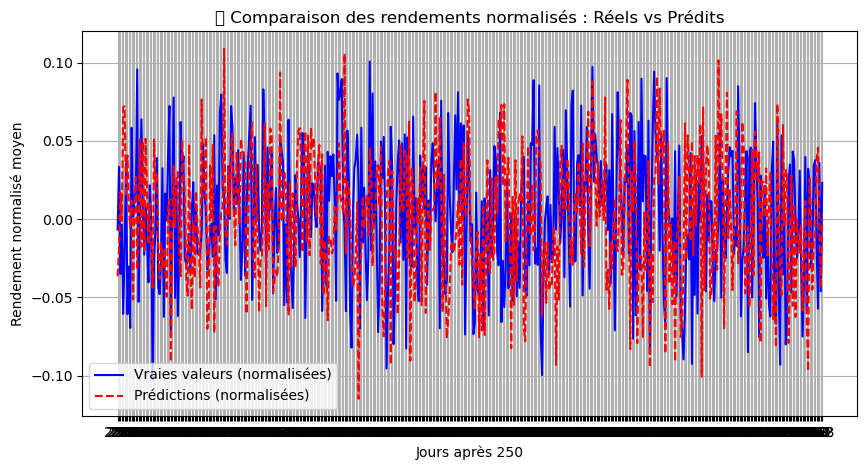

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


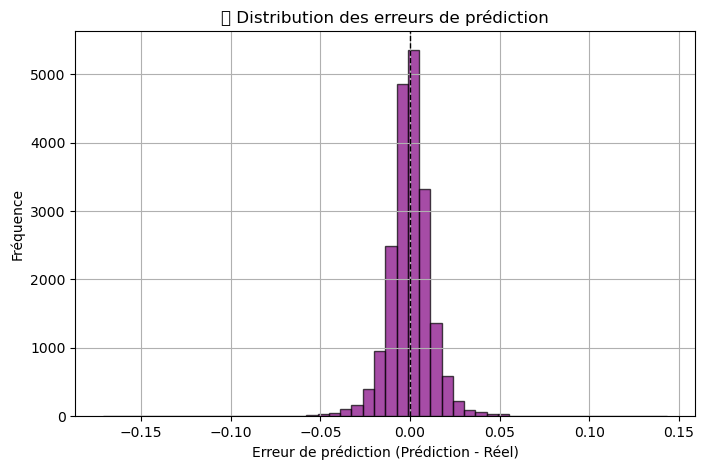

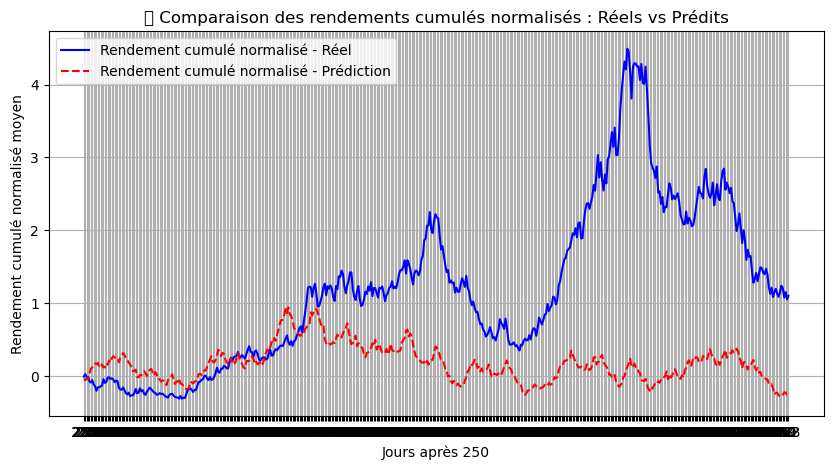

üîÑ üéâ Processus termin√© !...


In [28]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm  # Pour afficher la progression

# üîπ Fonction pour afficher des logs
def log(message):
    print(f"üîÑ {message}...")

# üîπ Pr√©paration des donn√©es
def prepare_data(X_train, Y_train):
    log("Pr√©paration des donn√©es")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

# üîπ Optimisation du mod√®le Random Forest en utilisant OOB Score
def optimize_random_forest_oob(X_train, Y_train):
    log("Optimisation du mod√®le Random Forest avec OOB Score")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_features': ['sqrt', 'log2', 0.5]  # S√©lection al√©atoire des features
    }

    best_model = None
    best_oob_score = float('-inf')
    best_params = None

    for params in tqdm(ParameterGrid(param_grid), desc="üîç Test d'hyperparam√®tres"):
        print(f"‚ñ∂Ô∏è Test : {params}")

        # üîπ Cr√©ation du mod√®le avec les param√®tres actuels
        model = RandomForestRegressor(
            oob_score=True,  # Activation du OOB Score
            random_state=42,
            n_jobs=-1,  # Utilisation de tous les c≈ìurs pour acc√©l√©rer l'entra√Ænement
            **params
        )

        model.fit(X_train, Y_train)  # OOB est calcul√© automatiquement

        # üîπ V√©rification du OOB Score
        if hasattr(model, "oob_score_"):  # Parfois oob_score_ peut ne pas exister
            oob_score = model.oob_score_
        else:
            oob_score = float('-inf')

        if oob_score > best_oob_score:  # Maximisation du OOB Score
            best_oob_score = oob_score
            best_model = model
            best_params = params

    print(f"‚úÖ Meilleurs param√®tres trouv√©s : {best_params} avec OOB Score = {best_oob_score:.4f}")
    return best_model

# üîπ Extraction des facteurs via Random Forest et r√©duction avec PCA
def extract_factors_from_rf(model, X_train, n_factors=10):
    log("Extraction des facteurs √† partir de Random Forest")

    A_rf = model.predict(X_train)  # Pr√©dictions utilis√©es comme facteurs

    # üîπ R√©duction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_rf)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

# üîπ Entra√Ænement et √©valuation du mod√®le
log("D√©but du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
rf_best_model = optimize_random_forest_oob(X_train_set, Y_train_set)
A = extract_factors_from_rf(rf_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du mod√®le : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("üéâ Processus termin√© !")
